# Import packages

In [54]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

In [55]:
SEED=123
np.random.seed(SEED)

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Set path

In [57]:
BASEPATH = '/home/ubuntu/w210_melanoma/data'

df_train_full = pd.read_csv(os.path.join(BASEPATH, 'metadata_train.csv'))

train_path = BASEPATH + '/train'
train_dir = pathlib.Path(train_path)

test_path = BASEPATH + '/ISIC_2020_Test_Input'
test_dir = pathlib.Path(test_path)

# Configurations

In [58]:
CFG = dict(
        batch_size        =  16,     
        epochs            =  50, #10,  
        verbose           =   1,   
        workers           =   4,   

        optimizer         = 'adam', 

        RANDOM_STATE      =  123,   
    
        # Path to save a model
        path_model        = '/home/ubuntu/w210_melanoma/model/',

        # Images sizes
        img_size          = 224, 
        img_height        = 224, 
        img_width         = 224, 

        # Postprocessing
        label_smooth_fac  =  0.00,      
)

# Data split and generation

In [59]:
#train_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)
#valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [60]:
train_generator = ImageDataGenerator(
                  rescale=1./255, 
                  validation_split=0.2,
                  rotation_range=90, # Rotate 90 degree
                  width_shift_range=0.3,
                  height_shift_range=0.3,
                  brightness_range=[0.2,1.0],
                  horizontal_flip = True,
                  vertical_flip = True,
                  )
valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [61]:
train_generator = train_generator.flow_from_directory(train_dir,
                                                    subset='training',                  
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    shuffle=True
                                                    )


valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',              
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

Found 26502 images belonging to 2 classes.
Found 6624 images belonging to 2 classes.


# Build the ResNet50

In [62]:
model_ResNet50 = tf.keras.Sequential([
     ResNet50(
        input_shape=(224, 224,3),
        weights='imagenet',
        include_top=False
    ),
    
    GlobalAveragePooling2D(),
     
    Dense(2, activation='softmax')
    
])

In [63]:
model_ResNet50.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=['accuracy']
)

In [64]:
model_ResNet50.layers[0].trainable = False

In [65]:
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


# Fit model

In [66]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

cb_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [67]:
#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(filepath = CFG['path_model']+'ResNet50-DA-whole-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor  = 'val_loss', 
                                   verbose  = CFG['verbose'], 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_lr_scheduler, cb_checkpointer]

history = model_ResNet50.fit(train_generator, 
                             epochs=CFG['epochs'], 
                             workers=CFG['workers'],
                             validation_data=valid_generator, 
                             callbacks = callbacks_list
                            )

Epoch 1/50
1657/1657 [==============================] - 2358s 1s/step - loss: 0.1147 - accuracy: 0.9788 - val_loss: 0.0904 - val_accuracy: 0.9825

Epoch 00001: val_loss improved from inf to 0.09045, saving model to /home/ubuntu/w210_melanoma/model/ResNet50-DA-whole-01-0.09.hdf5
Epoch 2/50
1657/1657 [==============================] - 2330s 1s/step - loss: 0.0959 - accuracy: 0.9812 - val_loss: 0.0961 - val_accuracy: 0.9825

Epoch 00002: val_loss did not improve from 0.09045
Epoch 3/50
1657/1657 [==============================] - 2309s 1s/step - loss: 0.0959 - accuracy: 0.9810 - val_loss: 0.0928 - val_accuracy: 0.9825

Epoch 00003: val_loss did not improve from 0.09045
Epoch 4/50
1657/1657 [==============================] - 2324s 1s/step - loss: 0.0910 - accuracy: 0.9823 - val_loss: 0.1190 - val_accuracy: 0.9825

Epoch 00004: val_loss did not improve from 0.09045
Epoch 5/50
1657/1657 [==============================] - 2351s 1s/step - loss: 0.0893 - accuracy: 0.9824 - val_loss: 0.0951 - va

1657/1657 [==============================] - 2319s 1s/step - loss: 0.0815 - accuracy: 0.9812 - val_loss: 0.0810 - val_accuracy: 0.9820

Epoch 00039: val_loss did not improve from 0.08036
Epoch 40/50
1657/1657 [==============================] - 2312s 1s/step - loss: 0.0763 - accuracy: 0.9830 - val_loss: 0.0809 - val_accuracy: 0.9820

Epoch 00040: val_loss did not improve from 0.08036
Epoch 41/50
1657/1657 [==============================] - 2287s 1s/step - loss: 0.0795 - accuracy: 0.9823 - val_loss: 0.0794 - val_accuracy: 0.9822

Epoch 00041: val_loss improved from 0.08036 to 0.07939, saving model to /home/ubuntu/w210_melanoma/model/ResNet50-DA-whole-41-0.08.hdf5
Epoch 42/50
1657/1657 [==============================] - 2287s 1s/step - loss: 0.0758 - accuracy: 0.9831 - val_loss: 0.0807 - val_accuracy: 0.9820

Epoch 00042: val_loss did not improve from 0.07939
Epoch 43/50
1657/1657 [==============================] - 2321s 1s/step - loss: 0.0771 - accuracy: 0.9827 - val_loss: 0.0806 - val_a

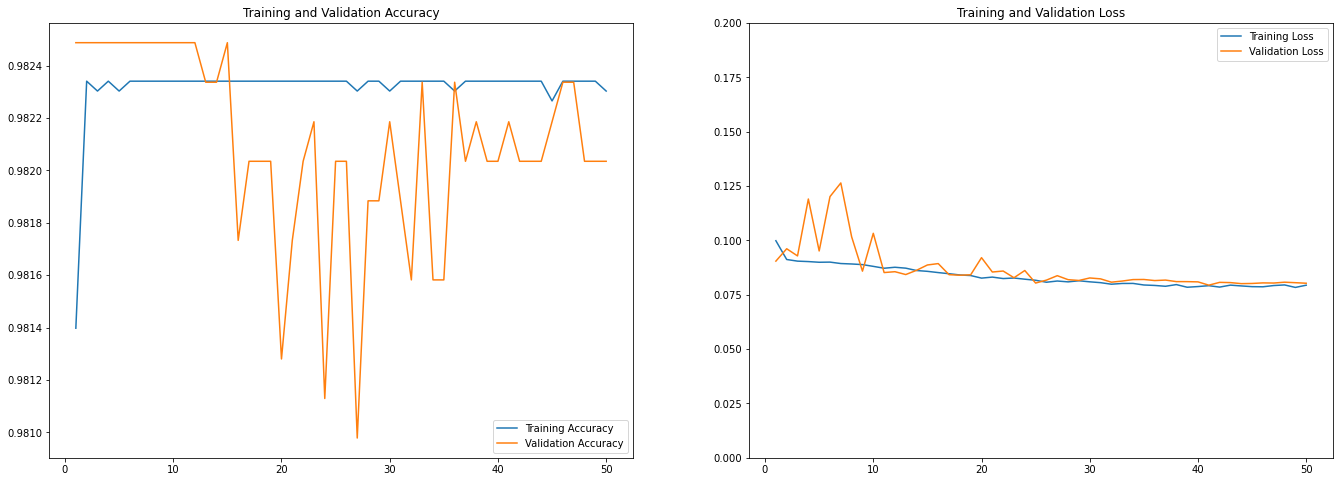

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.ylim([0, 0.2])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Make predictions on the Validation set and analyze the results

In [71]:
from tensorflow.keras.models import load_model

In [72]:
model = load_model('/home/ubuntu/w210_melanoma/model/ResNet50-DA-whole-41-0.08.hdf5')

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 23,538,690
Non-trainable params: 53,120
_________________________________________________________________


In [74]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                               validation_split=0.2, 
                                                               image_size=(224,224), 
                                                               subset="validation",
                                                               seed=SEED)

Found 33126 files belonging to 2 classes.
Using 6625 files for validation.


In [75]:
file_paths = valid_ds.file_paths

In [76]:
file_paths[1].split(os.sep)[-1][0:-4]

'ISIC_3223682'

In [77]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

In [78]:
valid_ds = valid_ds.map(process)

In [79]:
valid_images_ds = valid_ds.map(lambda image, idnum: image)

In [80]:
pred_probs = model.predict(valid_images_ds)

In [81]:
pred_probs.shape

(6625, 2)

In [83]:
pred_probs[:,1].min()

2.6797492e-08

In [84]:
valid_ids_ds = valid_ds.map(lambda image, idnum: idnum).unbatch()

In [85]:
valid_ids = next(iter(valid_ids_ds.batch(6625))).numpy().astype('U')

In [86]:
len(valid_ids)

6625

In [87]:
img_list = []
img_id_list = []
img_name_list = []
for i in range(len(file_paths)):
    img_list.append(file_paths[i].split(os.sep)[-1])
    img_id_list.append(i)
    img_name_list.append(file_paths[i].split(os.sep)[-1][0:-4])

img_name_list_by_ids = []
for iid in list(valid_ids):
    #print(int(iid),img_name_list[int(iid)],pred_probs[:,1][int(iid)]) 
    img_name_list_by_ids.append(img_name_list[int(iid)])

In [88]:
pred_df = pd.DataFrame({'image_name': img_name_list, 'pred_target': pred_probs[:,1]})
pred_df.head()

,image_name,pred_target
0,ISIC_3604231,0.001429
1,ISIC_3223682,0.000016
2,ISIC_5797220,0.000243
3,ISIC_5854870,0.000640
4,ISIC_3642241,0.000021


In [89]:
len(pred_df)

6625

In [90]:
df_train_full.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [91]:
pred_df = pd.merge(pred_df, df_train_full, on = ['image_name'], how = 'left')

In [92]:
TP, TN, FP, FN = 0, 0, 0, 0

for index, row in pred_df.iterrows():
    if row['target'] == 0:
        if row['pred_target'] < 0.5:
            TN += 1
        else:
            FP += 1
    else:
        if row['pred_target'] > 0.5:
            TP += 1
        else:
            FN += 1

In [93]:
np.seterr(divide='ignore', invalid='ignore')
print("True Positive:", TP)
print("True Negative:", TN)
print("False Positive:", FP)
print("False Negative:", FN)
print("------------------------------")
print("Accuracy:", (TP+TN)/(TP+TN+FP+FN))
print("Precision:", np.nan_to_num(np.divide(TP, TP+FP)))
print("Recall:", np.nan_to_num(np.divide(TN, TN+FN)))
print("F-1 Score:", 2*TP/(2*TP+FP+FN))

True Positive: 0
True Negative: 6495
False Positive: 2
False Negative: 128
------------------------------
Accuracy: 0.9803773584905661
Precision: 0.0
Recall: 0.9806734108410086
F-1 Score: 0.0
